# 02 · S3WD v02 主线：参考元组 + 相似度 + 漂移闭环

本 Notebook 演示 S3WD v02 流程：利用 Reference Tuple（参考元组）/混合相似度/批级阈值小网格，结合漂移分级响应（S1/S2/S3）。
运行前请确认 `configs/s3wd_airline_v02.yaml` 已更新至 v02 键位，并准备好 Airlines 数据。


In [16]:
import os
from pathlib import Path
import sys
import json
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / 's3wdlib').exists() and (PROJECT_ROOT.parent / 's3wdlib').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

print("【步骤0】环境信息：", {
    'python': sys.version.split()[0],
    'cwd': os.getcwd(),
    'project_root': str(PROJECT_ROOT)
})



【步骤0】环境信息： {'python': '3.11.5', 'cwd': 'e:\\yan\\组\\三支决策\\机器学习\\C三支决策与不平衡数据集分类\\S3WD实验\\notebooks', 'project_root': 'e:\\yan\\组\\三支决策\\机器学习\\C三支决策与不平衡数据集分类\\S3WD实验'}


In [17]:
from s3wdlib.config_loader import load_yaml_cfg, extract_vars, show_cfg
from s3wdlib import (
    augment_airline_features,
    run_streaming_flow,
    assign_buckets,
    build_ref_tuples,
    combine_history,
    corr_to_set,
    to_trisect_probs,
    expected_cost,
    expected_fbeta,
    select_alpha_beta,
    ema_clip,
    detect_drift,
    apply_actions,
    compute_region_masks,
)
import s3wdlib.bucketizer as bucketizer
import s3wdlib.similarity as similarity
import s3wdlib.drift_controller as drift_controller
from s3wdlib.gwb import GWBProbEstimator

CONFIG_PATH = Path('../configs/s3wd_airline_v02.yaml')
cfg = load_yaml_cfg(str(CONFIG_PATH))
show_cfg(cfg)
vars_flat = extract_vars(cfg)

bucketizer.configure(cfg.get('BUCKET'))
similarity.configure(cfg.get('SIMILARITY'))

sim_cfg = similarity.current_config()
drift_thresholds = {
    'psi_thresholds': cfg['DRIFT'].get('psi_thresholds'),
    'tv_thresholds': cfg['DRIFT'].get('tv_thresholds'),
    'posrate_shift': cfg['DRIFT'].get('posrate_shift'),
    'perf_drop': cfg['DRIFT'].get('perf_drop'),
    'debounce_windows': cfg['DRIFT'].get('debounce_windows', 1),
}
actions_cfg = cfg['DRIFT'].get('actions', {})


【配置快照】
- DATA: {'data_dir': '../data', 'data_file': 'airlines_train_regression_1000000.arff', 'continuous_label': 'DepDelay', 'threshold': 15, 'threshold_op': '>', 'test_size': 0.3, 'val_size': 0.3, 'random_state': 42, 'start_year': 2018}
- LEVEL: {'level_pcts': [0.6, 0.8, 1.0], 'ranker': 'mi'}
- KWB: {'k': 6, 'metric': 'euclidean', 'eps': 1e-06, 'use_faiss': True, 'faiss_gpu': True}
- GWB: {'k': 10, 'metric': 'euclidean', 'eps': 1e-06, 'mode': 'epanechnikov', 'bandwidth': 0.72, 'bandwidth_scale': 1.05, 'use_faiss': True, 'faiss_gpu': True, 'categorical_features': ['Origin', 'Dest'], 'category_penalty': 0.3}
- S3WD: {'c1': 0.37, 'c2': 0.63, 'xi_min': 0.1, 'theta_pos': 0.9, 'theta_neg': 0.1, 'sigma': 3.0, 'regret_mode': 'utility', 'penalty_large': 1000000.0, 'gamma_last': True, 'gap': 0.02}
- PSO: {'particles': 20, 'iters': 20, 'w_max': 0.9, 'w_min': 0.4, 'c1': 2.8, 'c2': 1.3, 'seed': 42, 'use_gpu': True}
- BUCKET: {'keys': ['UniqueCarrier', 'Origin', 'Dest', 'dep_hour'], 'min_bucket': 

In [18]:
from s3wdlib.data_io import load_table_auto
from s3wdlib.v02_flow import format_window_label, year_month_to_float

data_dir = Path(cfg['DATA']['data_dir'])
data_path = data_dir / cfg['DATA']['data_file']
X_raw, y = load_table_auto(
    str(data_path),
    continuous_label=cfg['DATA'].get('continuous_label'),
    threshold=cfg['DATA'].get('threshold'),
    threshold_op=cfg['DATA'].get('threshold_op')
)
X_enriched = augment_airline_features(X_raw)

month_col = None
for candidate in ['Month', 'month', 'MONTH']:
    if candidate in X_enriched.columns:
        month_col = candidate
        break
if month_col is None:
    raise KeyError('数据缺少 Month 列，无法拆分 year-month 窗口')

X_enriched[month_col] = X_enriched[month_col].astype(int)
if month_col != 'Month':
    X_enriched['Month'] = X_enriched[month_col].astype(int)

year_col = None
for candidate in ['Year', 'year', 'YEAR']:
    if candidate in X_enriched.columns:
        year_col = candidate
        break
if year_col is None:
    default_year = int(cfg.get('TIME', {}).get('default_year', 0))
    X_enriched['Year'] = default_year
    year_col = 'Year'
    print(f"【提醒】数据缺少 Year 列，已使用 default_year={default_year}")
else:
    X_enriched['Year'] = X_enriched[year_col].astype(int)
X_enriched['YearMonth'] = (
    X_enriched['Year'].astype(int).astype(str)
    + '-' +
    X_enriched['Month'].astype(int).map(lambda m: f"{int(m):02d}")
)
window_table = (
    X_enriched[['Year', 'Month', 'YearMonth']]
    .drop_duplicates()
    .sort_values(['Year', 'Month'])
)
base_year = int(window_table['Year'].min())
window_table['WindowLabel'] = window_table.apply(
    lambda row: year_month_to_float(int(row['Year']), int(row['Month']), base_year=base_year),
    axis=1,
)
window_table['WindowDisplay'] = window_table['WindowLabel'].map(format_window_label)
window_label_map = dict(zip(window_table['YearMonth'], window_table['WindowLabel']))
window_display_map = dict(zip(window_table['YearMonth'], window_table['WindowDisplay']))
window_sequence = window_table['YearMonth'].tolist()
window_sequence_fmt = [window_display_map[w] for w in window_sequence]

warmup_months = window_sequence[:6] if len(window_sequence) >= 6 else window_sequence[:-1]
stream_months = [w for w in window_sequence if w not in warmup_months]
warmup_fmt = [window_display_map[w] for w in warmup_months]
stream_fmt = [window_display_map[w] for w in stream_months]

train_mask = X_enriched['YearMonth'].isin(warmup_months)
X_train = X_enriched.loc[train_mask].reset_index(drop=True)
y_train = y.loc[train_mask].reset_index(drop=True)
X_stream = X_enriched.loc[~train_mask].reset_index(drop=True)
y_stream = y.loc[~train_mask].reset_index(drop=True)

print(f"【窗口序列】顺序={window_sequence_fmt}")
print(f"【窗口拆分】训练窗={warmup_fmt}，流式窗={stream_fmt}")
print("【窗口约束】不合并不同年份的同月；历史同月仅用于参考库。")
print(f"【数据划分】训练样本={len(X_train)}，流式样本={len(X_stream)}")

bucket_train = assign_buckets(X_train)
cat_cols = [c for c in ['UniqueCarrier','Origin','Dest','DayOfWeek','Month'] if c in X_train.columns]

gwb_cfg = cfg['GWB']
gwb_estimator = GWBProbEstimator(
    k=gwb_cfg.get('k', 6),
    metric=gwb_cfg.get('metric', 'euclidean'),
    eps=gwb_cfg.get('eps', 1e-6),
    mode=gwb_cfg.get('mode', 'epanechnikov'),
    bandwidth=gwb_cfg.get('bandwidth'),
    bandwidth_scale=gwb_cfg.get('bandwidth_scale', 1.0),
    use_faiss=gwb_cfg.get('use_faiss', True),
    faiss_gpu=gwb_cfg.get('faiss_gpu', True),
    categorical_features=cat_cols,
    category_penalty=gwb_cfg.get('category_penalty', 0.5),
)
gwb_estimator.fit(
    X_train.values,
    y_train.to_numpy(),
    categorical_values=X_train[cat_cols] if cat_cols else None,
)

if cfg['REF_TUPLE'].get('use_gwb_weight', True):
    gwb_prob_train = gwb_estimator.predict_proba(
        X_train.values,
        categorical_values=X_train[cat_cols] if cat_cols else None,
    )
else:
    gwb_prob_train = None

ref_tuples = build_ref_tuples(
    X_train,
    y_train.to_numpy(),
    bucket_train,
    topk_per_class=cfg['REF_TUPLE'].get('topk_per_class', 256),
    pos_quantile=cfg['REF_TUPLE'].get('pos_quantile', 0.7),
    keep_history_ratio=cfg['REF_TUPLE'].get('keep_history_ratio', 0.3),
    gwb_prob=gwb_prob_train,
)
print(f"【训练资产】参考元组覆盖桶数量={len(ref_tuples)}")

def compute_similarity_block(X_block, bucket_ids, ref_map, sigma, sim_params):
    cat_weights = sim_params.get('cat_weights', {})
    combine = sim_params.get('combine', 'product')
    mix_alpha = sim_params.get('mix_alpha', 0.7)
    E_pos = np.zeros(len(X_block), dtype=float)
    E_neg = np.zeros(len(X_block), dtype=float)
    index_map = {}
    for idx, bucket in enumerate(bucket_ids):
        index_map.setdefault(str(bucket), []).append(idx)
    for bucket_id, positions in index_map.items():
        refs = ref_map.get(bucket_id)
        if not refs:
            continue
        subset = X_block.iloc[positions]
        if refs.get('pos'):
            E_pos[positions] = corr_to_set(
                subset, refs['pos'], sigma, cat_weights, combine=combine, mix_alpha=mix_alpha
            )
        if refs.get('neg'):
            E_neg[positions] = corr_to_set(
                subset, refs['neg'], sigma, cat_weights, combine=combine, mix_alpha=mix_alpha
            )
    return E_pos, E_neg

def calc_distribution_metrics(base_probs, curr_probs, bins):
    base_hist, _ = np.histogram(base_probs, bins=bins)
    curr_hist, _ = np.histogram(curr_probs, bins=bins)
    base_ratio = np.clip(base_hist / max(base_hist.sum(), 1), 1e-6, None)
    curr_ratio = np.clip(curr_hist / max(curr_hist.sum(), 1), 1e-6, None)
    psi = float(np.sum((curr_ratio - base_ratio) * np.log(curr_ratio / base_ratio)))
    tv = float(0.5 * np.sum(np.abs(curr_ratio - base_ratio)))
    return psi, tv

E_pos_train, E_neg_train = compute_similarity_block(
    X_train, bucket_train, ref_tuples, sigma=sim_cfg.get('sigma', 0.5), sim_params=sim_cfg
)
P_train = to_trisect_probs(E_pos_train, E_neg_train)

objective = cfg['MEASURE'].get('objective', 'expected_cost')
measure_grid = cfg['MEASURE'].get('grid', {'alpha': [0.55, 0.9, 0.02], 'beta': [0.05, 0.45, 0.02]})
measure_constraints = cfg['MEASURE'].get('constraints', {})
measure_costs = cfg['MEASURE'].get('costs', {})
beta_weight = cfg['MEASURE'].get('beta_weight', 1.0)

alpha_prev, beta_prev, base_score = select_alpha_beta(
    P_train, measure_grid, measure_constraints, objective=objective, costs=measure_costs, beta_weight=beta_weight
)
if objective == 'expected_cost':
    baseline_perf = expected_cost(
        P_train,
        alpha_prev,
        beta_prev,
        measure_costs.get('c_fn', 1.0),
        measure_costs.get('c_fp', 1.0),
        measure_costs.get('c_bnd', 0.5),
    )
else:
    baseline_perf = expected_fbeta(P_train, alpha_prev, beta_prev, beta_weight=beta_weight)

baseline_bins = np.linspace(0, 1, 11)
baseline_info = {
    'p_pos': P_train['p_pos'],
    'posrate': float(y_train.mean()),
    'perf': baseline_perf,
    'bins': baseline_bins,
}

runtime_state = {
    'sigma': sim_cfg.get('sigma', 0.5),
    'constraints': dict(measure_constraints),
    'step_cap': dict(cfg['SMOOTH'].get('step_cap', {'alpha': 0.08, 'beta': 0.08})),
    'actions_cfg': actions_cfg,
    'keep_history_ratio': cfg['REF_TUPLE'].get('keep_history_ratio', 0.3),
    'use_gwb_weight': cfg['REF_TUPLE'].get('use_gwb_weight', True),
    'ref_tuples': ref_tuples,
    'gwb_estimator': gwb_estimator,
    'cat_weights': sim_cfg.get('cat_weights', {}),
    'combine': sim_cfg.get('combine', 'product'),
    'mix_alpha': sim_cfg.get('mix_alpha', 0.7),
}
history_records = [
    {
        'X': X_train.copy(),
        'y': y_train.to_numpy(),
        'buckets': bucket_train.copy(),
        'gwb': gwb_prob_train if gwb_prob_train is not None else None,
    }
]

print(f"【训练阈值】α0={alpha_prev:.3f}，β0={beta_prev:.3f}，基线性能={baseline_perf:.4f}")
print(f"【状态初始化】sigma={runtime_state['sigma']:.3f}")



【数据加载完毕】样本数=1000000，特征数=9，正类比例=0.1559
【数据划分】训练窗=[1, 2, 3, 4, 5, 6]，流式窗=[7, 8, 9, 10, 11, 12]，训练样本=501064，流式样本=498936
【训练资产】参考元组覆盖桶数量=445
【训练阈值】α0=0.550，β0=0.310，基线性能=0.0850
【状态初始化】sigma=0.500


In [19]:
from s3wdlib.v02_flow import format_window_label, year_month_to_float
threshold_trace = []
window_metrics = []
drift_events = []
max_history_windows = 6
metric_name = '预计成本' if objective == 'expected_cost' else '期望Fβ'

if not stream_months:
    print("【提示】当前数据不足以拆分流式窗口，请调整 warmup_months。")

for window in stream_months:
    window_key = str(window)
    if '-' in window_key:
        year_str, month_str = window_key.split('-', 1)
    else:
        year_str, month_str = window_key[:4], window_key[-2:]
    try:
        year_val = int(year_str)
    except ValueError:
        year_val = int(''.join(ch for ch in year_str if ch.isdigit()) or 0)
    try:
        month_val = int(month_str)
    except ValueError:
        month_val = int(''.join(ch for ch in month_str if ch.isdigit()) or 0)
    window_value = window_label_map.get(window_key)
    if window_value is None:
        window_value = year_month_to_float(year_val, month_val, base_year=base_year)
    window_display = window_display_map.get(window_key, format_window_label(window_value))

    block_mask = X_enriched['YearMonth'] == window_key
    X_block = X_enriched.loc[block_mask].reset_index(drop=True)
    y_block = y.loc[block_mask].reset_index(drop=True)
    if X_block.empty:
        continue

    sample_count = len(X_block)
    buckets_block = assign_buckets(X_block)
    E_pos_block, E_neg_block = compute_similarity_block(
        X_block,
        buckets_block,
        runtime_state['ref_tuples'],
        sigma=runtime_state.get('sigma', 0.5),
        sim_params=runtime_state,
    )
    P_block = to_trisect_probs(E_pos_block, E_neg_block)

    alpha_star, beta_star, grid_score = select_alpha_beta(
        P_block,
        measure_grid,
        runtime_state['constraints'],
        objective=objective,
        costs=measure_costs,
        beta_weight=beta_weight,
    )

    step_caps = runtime_state.get('step_cap', {'alpha': 0.08, 'beta': 0.08})
    alpha_smooth, beta_smooth = ema_clip(
        alpha_star,
        beta_star,
        alpha_prev,
        beta_prev,
        cfg['SMOOTH'].get('ema_alpha', 0.6),
        step_caps.get('alpha', 0.08),
        step_caps.get('beta', 0.08),
    )
    if alpha_prev is None or beta_prev is None:
        alpha_smooth, beta_smooth = alpha_star, beta_star

    alpha_prev, beta_prev = alpha_smooth, beta_smooth

    positive, negative, boundary = compute_region_masks(P_block, alpha_smooth, beta_smooth)
    pos_cov = float(positive.mean())
    bnd_ratio = float(boundary.mean())

    if objective == 'expected_cost':
        score_smoothed = expected_cost(
            P_block,
            alpha_smooth,
            beta_smooth,
            measure_costs.get('c_fn', 1.0),
            measure_costs.get('c_fp', 1.0),
            measure_costs.get('c_bnd', 0.5),
        )
        perf_drop = max(0.0, score_smoothed - baseline_info['perf'])
    else:
        score_smoothed = expected_fbeta(P_block, alpha_smooth, beta_smooth, beta_weight=beta_weight)
        perf_drop = max(0.0, baseline_info['perf'] - score_smoothed)

    psi_val, tv_val = calc_distribution_metrics(baseline_info['p_pos'], P_block['p_pos'], baseline_info['bins'])
    posrate_curr = float(y_block.mean())
    posrate_gap = abs(posrate_curr - baseline_info['posrate'])

    stats_curr = {
        'window_id': window_value,
        'psi': psi_val,
        'tv': tv_val,
        'posrate': posrate_gap,
        'perf_drop': perf_drop,
    }
    sigma_before = runtime_state.get('sigma', 0.5)
    drift_level = detect_drift(stats_curr, baseline_info, drift_thresholds)
    runtime_state = apply_actions(drift_level, runtime_state)

    rebuild_tuple_flag = runtime_state.get('rebuild_ref_tuple', False)
    rebuild_gwb_flag = runtime_state.get('rebuild_gwb_index', False)
    redo_flag = runtime_state.get('redo_threshold', False)

    actions_taken = []
    if drift_level != 'NONE':
        if runtime_state.get('sigma', sigma_before) != sigma_before:
            actions_taken.append(f"调σ→{runtime_state['sigma']:.3f}")
        if rebuild_tuple_flag:
            actions_taken.append('重建参考元组')
        if rebuild_gwb_flag:
            actions_taken.append('重建GWB索引')
        if redo_flag:
            actions_taken.append('阈值重置')

    if redo_flag:
        alpha_prev, beta_prev = None, None
        runtime_state['redo_threshold'] = False

    if rebuild_tuple_flag or rebuild_gwb_flag:
        combined_X = pd.concat([rec['X'] for rec in history_records], ignore_index=True)
        combined_y = np.concatenate([rec['y'] for rec in history_records])
        combined_buckets = assign_buckets(combined_X)
        combined_gwb = None
        if runtime_state.get('gwb_estimator') is not None:
            if rebuild_gwb_flag:
                runtime_state['gwb_estimator'].fit(
                    combined_X.values,
                    combined_y,
                    categorical_values=combined_X[cat_cols] if cat_cols else None,
                )
                if '重建GWB索引' in actions_taken:
                    idx = actions_taken.index('重建GWB索引')
                    actions_taken[idx] = 'GWB索引已重建'
                else:
                    actions_taken.append('GWB索引已重建')
            if runtime_state.get('use_gwb_weight', True):
                combined_gwb = runtime_state['gwb_estimator'].predict_proba(
                    combined_X.values,
                    categorical_values=combined_X[cat_cols] if cat_cols else None,
                )
        if rebuild_tuple_flag:
            new_refs = build_ref_tuples(
                combined_X,
                combined_y,
                combined_buckets,
                topk_per_class=cfg['REF_TUPLE'].get('topk_per_class', 256),
                pos_quantile=cfg['REF_TUPLE'].get('pos_quantile', 0.7),
                keep_history_ratio=runtime_state.get('keep_history_ratio', 0.3),
                gwb_prob=combined_gwb,
            )
            runtime_state['ref_tuples'] = combine_history(
                new_refs,
                runtime_state.get('ref_tuples'),
                runtime_state.get('keep_history_ratio', 0.3),
            )
            if '重建参考元组' in actions_taken:
                idx = actions_taken.index('重建参考元组')
                actions_taken[idx] = '参考元组已重建'
            else:
                actions_taken.append('参考元组已重建')
        runtime_state['rebuild_ref_tuple'] = False
        runtime_state['rebuild_gwb_index'] = False

    similarity.configure({'sigma': runtime_state.get('sigma', 0.5)})

    threshold_trace.append({
        'window': window_value,
        'year': year_val,
        'month': month_val,
        'alpha_star': float(alpha_star),
        'beta_star': float(beta_star),
        'alpha_smoothed': float(alpha_smooth),
        'beta_smoothed': float(beta_smooth),
        'objective_score': float(score_smoothed),
        'bnd_ratio': bnd_ratio,
        'pos_coverage': pos_cov,
    })

    window_metrics.append({
        'window': window_value,
        'year': year_val,
        'month': month_val,
        'n_samples': int(sample_count),
        'psi': float(psi_val),
        'tv': float(tv_val),
        'posrate_gap': float(posrate_gap),
        'posrate': posrate_curr,
        'perf_drop': float(perf_drop),
        'BND_ratio': bnd_ratio,
        'POS_coverage': pos_cov,
        'alpha': float(alpha_smooth),
        'beta': float(beta_smooth),
    })

    print(
        f"【窗口评估】窗口={window_display} 样本={sample_count} α*={alpha_star:.3f}/β*={beta_star:.3f} → α_t={alpha_smooth:.3f}/β_t={beta_smooth:.3f} "
        f"BND={bnd_ratio:.3f} POS={pos_cov:.3f} {metric_name}={score_smoothed:.4f}"
    )

    if drift_level != 'NONE':
        drift_events.append({
            'window': window_value,
            'year': year_val,
            'month': month_val,
            'level': drift_level,
            'psi': float(psi_val),
            'tv': float(tv_val),
            'posrate_gap': float(posrate_gap),
            'perf_drop': float(perf_drop),
            'actions': '、'.join(actions_taken) if actions_taken else '观察',
        })
        print(
            f"【漂移】级别={drift_level} 动作={'、'.join(actions_taken) if actions_taken else '观察'} 生效范围=ref/next，窗口={window_display}"
        )
        if drift_level == 'S3':
            baseline_info['p_pos'] = P_block['p_pos']
            baseline_info['posrate'] = posrate_curr
            baseline_info['perf'] = score_smoothed

    gwb_prob_block = None
    if runtime_state.get('gwb_estimator') is not None and runtime_state.get('use_gwb_weight', True):
        gwb_prob_block = runtime_state['gwb_estimator'].predict_proba(
            X_block.values,
            categorical_values=X_block[cat_cols] if cat_cols else None,
        )
    history_records.append({
        'X': X_block.copy(),
        'y': y_block.to_numpy(),
        'buckets': buckets_block.copy(),
        'gwb': gwb_prob_block,
    })
    if len(history_records) > max_history_windows:
        history_records.pop(1)




【阈值选择】窗口=7 α*=0.550 β*=0.310 平滑后α=0.550 β=0.310 BND占比=0.343 预计成本=0.0850
【阈值选择】窗口=8 α*=0.550 β*=0.310 平滑后α=0.550 β=0.310 BND占比=0.340 预计成本=0.0855
【阈值选择】窗口=9 α*=0.550 β*=0.310 平滑后α=0.550 β=0.310 BND占比=0.342 预计成本=0.0851
【阈值选择】窗口=10 α*=0.550 β*=0.310 平滑后α=0.550 β=0.310 BND占比=0.340 预计成本=0.0862
【阈值选择】窗口=11 α*=0.550 β*=0.310 平滑后α=0.550 β=0.310 BND占比=0.347 预计成本=0.0847
【阈值选择】窗口=12 α*=0.550 β*=0.310 平滑后α=0.550 β=0.310 BND占比=0.346 预计成本=0.0845


In [ ]:
# 利用封装的 run_streaming_flow 前滚整个 v02 流程
flow_results = run_streaming_flow(str(CONFIG_PATH))
flow_threshold_df = flow_results['threshold_trace']
flow_metrics_df = flow_results['window_metrics']
flow_drift_df = flow_results['drift_events']
metrics_by_year = flow_results.get('metrics_by_year')
yearly_metrics = flow_results.get('yearly_metrics', metrics_by_year)
window_order = flow_results.get('window_order', {})
print(f"【窗口序列】暖启动={window_order.get('warmup', [])}")
print(f"【窗口序列】流式={window_order.get('stream', [])}")
print("【窗口约束】不合并不同年份的同月；历史同月仅用于参考库。")
display(flow_threshold_df.head(3))
display(flow_metrics_df.head(3))
display(yearly_metrics)



## 年度汇总

年度指标按样本数加权平均，以下折线展示 Precision/Recall/F1/BAC/MCC/Kappa/AUC/BND_ratio/POS_coverage 的年度走势。


【导出】阈值轨迹已保存到 E:\yan\组\三支决策\机器学习\C三支决策与不平衡数据集分类\S3WD实验\data\threshold_trace_v02.csv
【导出】窗口指标已保存到 E:\yan\组\三支决策\机器学习\C三支决策与不平衡数据集分类\S3WD实验\data\window_metrics.csv
【导出】漂移事件已保存到 E:\yan\组\三支决策\机器学习\C三支决策与不平衡数据集分类\S3WD实验\data\drift_events.csv


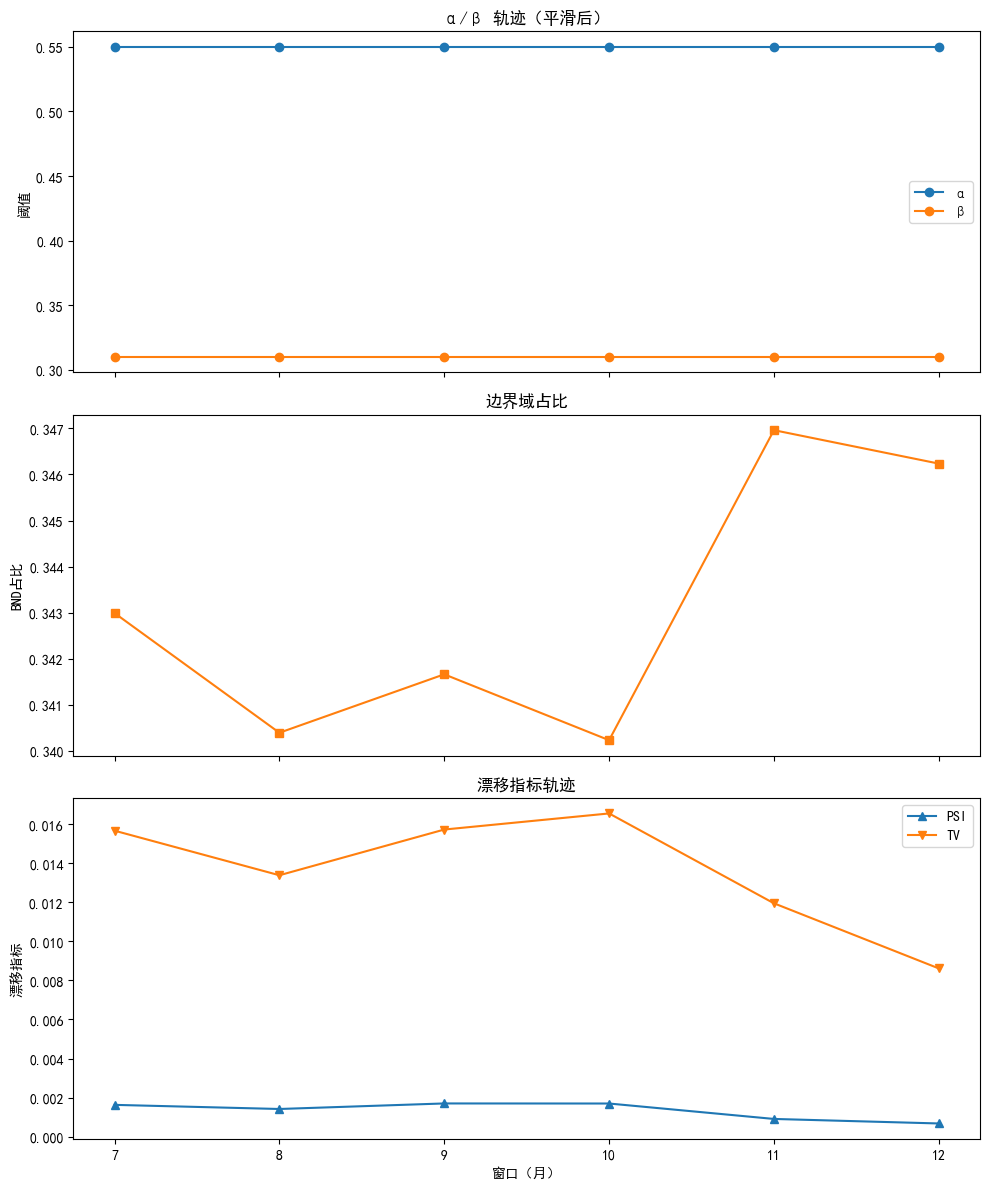

In [20]:
# 汇总阈值轨迹 / 漂移事件，并输出可视化与年度指标
trace_df = flow_threshold_df.copy() if 'flow_threshold_df' in globals() else pd.DataFrame(threshold_trace)
metrics_df = flow_metrics_df.copy() if 'flow_metrics_df' in globals() else pd.DataFrame(window_metrics)
drift_df = flow_drift_df.copy() if 'flow_drift_df' in globals() else pd.DataFrame(drift_events)
metrics_by_year_df = None
if 'yearly_metrics' in globals():
    metrics_by_year_df = yearly_metrics.copy()
elif 'metrics_by_year' in globals():
    metrics_by_year_df = metrics_by_year.copy()
else:
    metrics_by_year_df = pd.DataFrame()

output_dir = Path(cfg['DATA']['data_dir']).resolve()
output_dir.mkdir(parents=True, exist_ok=True)

trace_path = output_dir / 'threshold_trace_v02.csv'
metrics_path = output_dir / 'window_metrics.csv'
drift_path = output_dir / 'drift_events.csv'
year_metrics_path = output_dir / 'yearly_metrics.csv'

if not trace_df.empty:
    trace_df.to_csv(trace_path, index=False)
    print(f'【导出】阈值轨迹已保存到 {trace_path}')
if not metrics_df.empty:
    metrics_df.to_csv(metrics_path, index=False)
    print(f'【导出】窗口指标已保存到 {metrics_path}')
if not drift_df.empty:
    drift_df.to_csv(drift_path, index=False)
    print(f'【导出】漂移事件已保存到 {drift_path}')
if metrics_by_year_df is not None and not metrics_by_year_df.empty:
    if 'year' in metrics_by_year_df.columns:
        metrics_by_year_df = metrics_by_year_df.set_index('year')
    metrics_by_year_df.to_csv(year_metrics_path)
    print(f'【导出】年度指标已保存到 {year_metrics_path}')

if not trace_df.empty and not metrics_df.empty:
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    axes[0].plot(trace_df['window'], trace_df['alpha_smoothed'], label='α', marker='o')
    axes[0].plot(trace_df['window'], trace_df['beta_smoothed'], label='β', marker='o')
    axes[0].set_ylabel('阈值')
    axes[0].set_title('α/β 轨迹（平滑后）')
    axes[0].legend()

    bnd_col = 'BND_ratio' if 'BND_ratio' in metrics_df.columns else ('bnd_ratio' if 'bnd_ratio' in metrics_df.columns else None)
    if bnd_col is not None:
        axes[1].plot(metrics_df['window'], metrics_df[bnd_col], color='tab:orange', marker='s')
    bnd_cap = cfg['MEASURE'].get('constraints', {}).get('bnd_cap')
    if bnd_cap is not None:
        axes[1].axhline(bnd_cap, color='tab:gray', linestyle='--', label='bnd_cap')
    axes[1].set_ylabel('BND占比')
    axes[1].set_title('边界域占比')
    axes[1].legend()

    axes[2].plot(metrics_df['window'], metrics_df['psi'], label='PSI', marker='^')
    axes[2].plot(metrics_df['window'], metrics_df['tv'], label='TV', marker='v')
    axes[2].set_ylabel('漂移指标')
    axes[2].set_xlabel('窗口（year-month）')
    axes[2].set_title('漂移指标轨迹')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
else:
    print('【提示】流式窗口为空，未生成阈值/漂移图表。')

if metrics_by_year_df is not None and not metrics_by_year_df.empty:
    years = metrics_by_year_df.index.astype(int)
    metric_titles = [
        ('Precision', 'Precision'),
        ('Recall', 'Recall'),
        ('F1', 'F1'),
        ('BAC', 'BAC'),
        ('MCC', 'MCC'),
        ('Kappa', 'Kappa'),
        ('AUC', 'AUC'),
        ('BND_ratio', 'BND_ratio'),
        ('POS_coverage', 'POS_coverage'),
    ]
    for column, title in metric_titles:
        if column not in metrics_by_year_df.columns:
            continue
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(years, metrics_by_year_df[column], marker='o', linewidth=2)
        ax.set_xlabel('年份')
        ax.set_ylabel(column)
        ax.set_title(f'{title} 年度走势')
        ax.grid(alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.show()
else:
    print('【提示】年度指标暂不可用。')
